##Preparación de los datos

####Importe de librerías

Importamos el módulo de Drive para trabajar en una carpeta compartida

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Importamos ahora las librerías necesarias para nuestro proyecto

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn.linear_model
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

#Año 2021

####Lectura y visualización del Dataset

Leemos, utilizando pandas, el Dataset y lo cargamos en formato DataFrame. El 2021 se tomó por aparte porque los datos los encontramos en dos archivos distintos.

In [ ]:
data = pd.read_csv('gdrive/MyDrive/Proyecto1_CienciaDatos/world-happiness-report-2021.csv')

Visualizamos las primeras 5 filas y todas las columnas

In [ ]:
data.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798


Escogemos nuestra columna objetivo; **Ladder Score**, y los 6 predictores; **Logged GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity** y **Perceptions of corruption.** Se escogieron estas columnas porque son las tienen ambos datasets en común.

In [ ]:
keys = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']

Y = data['Ladder score']
X = data[keys]

Y guardamos en una variable local el promedio de felicidad mundial en el año 2021

In [ ]:
avg2021 = np.mean(Y)

Finalmente, graficamos cada uno de estos parámetros contra el **Ladder score** para buscar cualitativamente correlaciones.

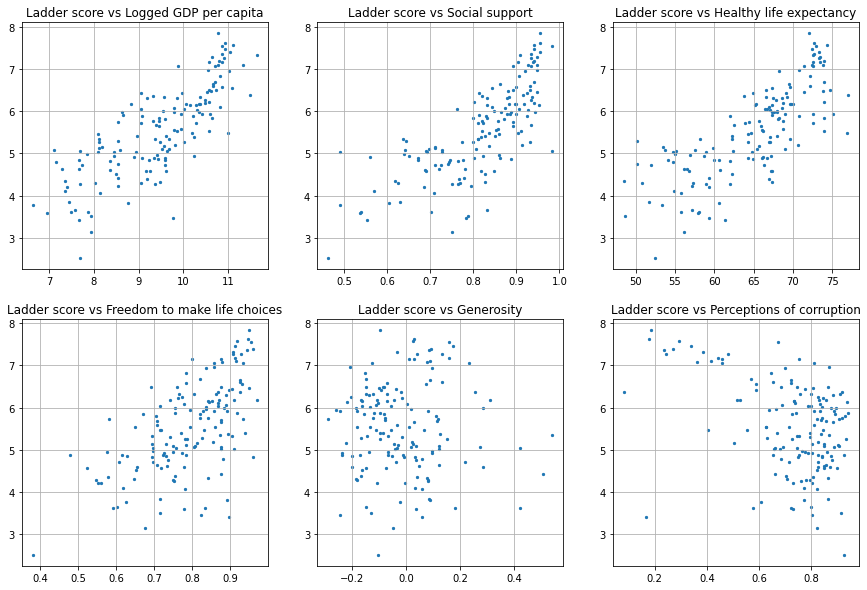

In [ ]:
fig = plt.figure(figsize=(15,10))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.scatter(X[keys[i]],Y, s=5)
  plt.title('Ladder score vs {}'.format(data.columns[i+6]))
  plt.grid()
plt.savefig('gdrive/MyDrive/Proyecto1_CienciaDatos/images/LadderScoreVsRelations.png', dpi=200)

##Definición y entrenamiento del modelo

En primer lugar, estandarizamos los datos para obtener los pesos de los $\beta$'s

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Escogemos aleatoriamente un $70\%$ de los datos como entrenamiento y un $30\%$ de ellos los dejamos para validación. Debido a la poca cantidad de datos (~150), realizamos un proceso de **Bootstrapping** con los $\beta$'s del modelo y el R$^2$.

In [ ]:
betasBoots = []
for i in range(7):
  betasBoots.append([])

rSquareBoots = []
n_iteraciones = 10000

for i in tqdm(range(n_iteraciones)):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
  regresion = sklearn.linear_model.LinearRegression()
  regresion.fit(X_train, Y_train)

  score = regresion.score(X_test, Y_test)
  intercept = regresion.intercept_ 
  betas = regresion.coef_

  rSquareBoots.append(score)
  betasBoots[0].append(regresion.intercept_)
  for i in range(6):
    betasBoots[i+1].append(betas[i])

100%|██████████| 10000/10000 [00:16<00:00, 599.65it/s]


Así pues, visualizamos los resultados de nuestra iteración para verificar el score $R^2$ de nuestro algoritmo de regresión

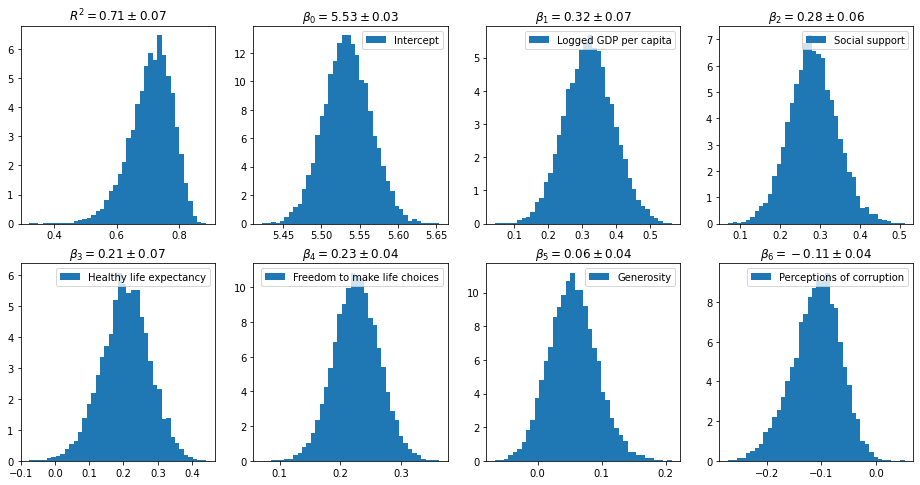

In [ ]:
betasMean2021 = []

fig = plt.figure(figsize=(16,8))

plt.subplot(2,4,1)
plt.hist(rSquareBoots, bins=40, density=True)
plt.title(r'$R^2=  {:.2f} \pm {:.2f}$'.format(np.mean(rSquareBoots), np.std(rSquareBoots)))

plt.subplot(2,4,2)
plt.hist(betasBoots[0], bins=40, density=True, label='Intercept')
plt.legend()
plt.title(r'$\beta _0=  {:.2f} \pm {:.2f}$'.format(np.mean(betasBoots[0]), np.std(betasBoots[0])))
betasMean2021.append(np.mean(betasBoots[0]))

for i in range(6):
  plt.subplot(2, 4, i+3)
  plt.hist(betasBoots[i+1], bins=40, density=True, label=keys[i])
  plt.legend()
  plt.title(r'$\beta _{}=  {:.2f} \pm {:.2f}$'.format(i+1, np.mean(betasBoots[i+1]), np.std(betasBoots[i+1])))
  betasMean2021.append(np.mean(betasBoots[i+1]))
plt.savefig('gdrive/MyDrive/Proyecto1_CienciaDatos/images/Parameters2021.png', dpi=200)

Y para mostrar la precisión del modelo, graficamos finalmente el **Ladder Score** contra todos los parámetros junto a los datos dados por la predicción.

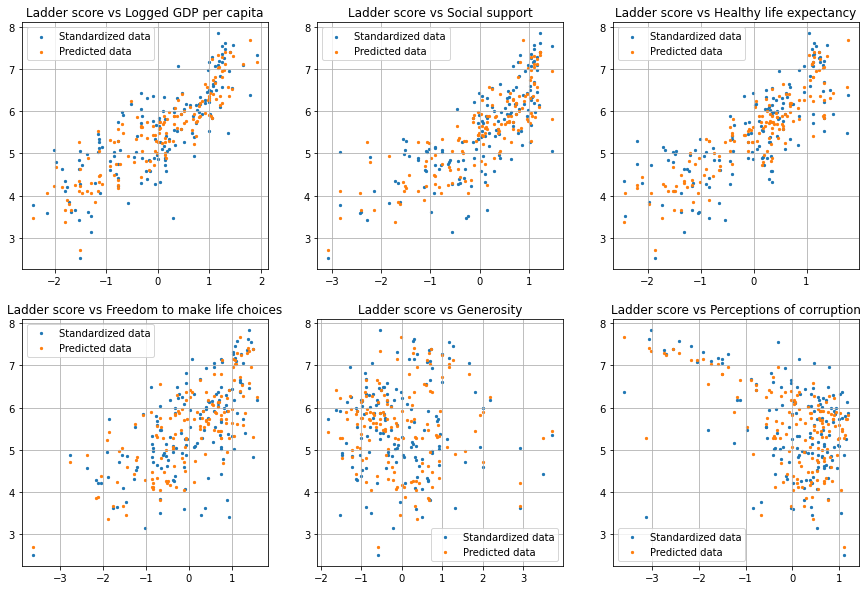

In [ ]:
fig = plt.figure(figsize=(15,10))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.scatter(X[:,i],Y, s=5, label='Standardized data')
  plt.scatter(X[:,i], regresion.predict(X), s=5, label='Predicted data')
  plt.title('Ladder score vs {}'.format(data.columns[i+6]))
  plt.legend()
  plt.grid()
plt.savefig('gdrive/MyDrive/Proyecto1_CienciaDatos/images/PredictedData.png', dpi=200)

#Años 2007-2020

####Lectura y visualización del Dataset

Posteriormente, repetimos el proceso con los demás años.

In [ ]:
data = pd.read_csv('gdrive/MyDrive/Proyecto1_CienciaDatos/world-happiness-report.csv')
data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


Como puede notarse, a diferencia del otro CSV, éste cuenta con una columna en donde se especifica el año al que hacen parte los datos. Por lo que debemos segmentar el dataset en 11

In [ ]:
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
yearsAll = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

dataYears = {}

for year in years:
  dataYears[year] = data[data['year'] == year]

##Definición y entrenamiento de los modelos

Escogemos las llaves para este Dataset (las cuales son un poco distintas a las del 2021)

In [ ]:
keys = ['Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']

Ahora, realizamos un modelo lineal con el $30\%$ de los datos en testeo, acompañado de un proceso de Bootstrapping para cada uno de los años, tal como se hizo con el 2021, para luego guardar todos los parámetros encontrados en listas y diccionarios.

In [ ]:
betasYears = {}
rSquareYears = {}

for year in tqdm(years):
  Y = dataYears[year]['Life Ladder']
  X = dataYears[year][keys].fillna(0)

  scaler = StandardScaler()
  scaler.fit(X)
  X = scaler.transform(X)

  betasBoots = []
  for i in range(7):
    betasBoots.append([])

  rSquareBoots = []
  n_iteraciones = 10000

  for i in range(n_iteraciones):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1)
    regresion = sklearn.linear_model.LinearRegression()
    regresion.fit(X_train, Y_train)

    score = regresion.score(X_test, Y_test)
    intercept = regresion.intercept_ 
    betas = regresion.coef_

    rSquareBoots.append(score)
    betasBoots[0].append(regresion.intercept_)
    for i in range(6):
      betasBoots[i+1].append(betas[i])

  betasYears[year] = betasBoots
  rSquareYears[year] = rSquareBoots

100%|██████████| 14/14 [02:59<00:00, 12.83s/it]


Podemos así hallar un promedio para cada uno de nuestros coeficientes $\beta$ a lo largo de los años y buscar cuál es el parámetro que más influye en la calidad de vida. 

In [ ]:
betasMeanYears = []
for i in range(7):
  betasMeanYears.append([])

for i in range(7):
  for j in range(len(years)):
    betasMeanYears[i].append(np.mean(betasYears[years[j]][i]))
  betasMeanYears[i].append(betasMean2021[i])

Graficamos ahora el peso de los diferentes parámetros a lo largo de los años.

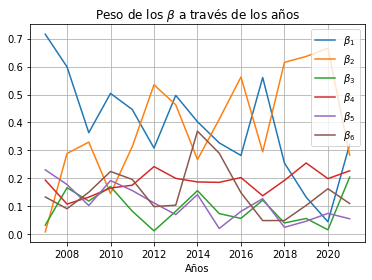

In [ ]:
plt.figure()
for i in range(6):
  plt.plot(yearsAll, np.abs(betasMeanYears[i+1]), label=r'$\beta_{}$'.format(i+1))
plt.legend()
plt.xlabel('Años')
plt.title(r'Peso de los $\beta$ a través de los años')
plt.grid()
plt.savefig('gdrive/MyDrive/Proyecto1_CienciaDatos/images/BetasYears.png', dpi=200)

Finalmente, podemos graficar el promedio de felicidad mundial a través de los años

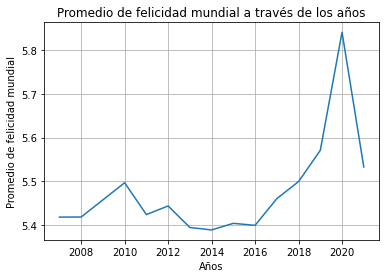

In [ ]:
avgs = [np.mean(dataYears[x]['Life Ladder']) for x in years]
avgs.append(avg2021)

plt.plot(yearsAll, avgs)
plt.ylabel('Promedio de felicidad mundial')
plt.xlabel('Años')
plt.title('Promedio de felicidad mundial a través de los años')
plt.grid()
plt.savefig('gdrive/MyDrive/Proyecto1_CienciaDatos/images/AvgYearHappiness.png', dpi=200)